In [ ]:
 cd /content/drive/MyDrive/ColabNotebooks

[Errno 2] No such file or directory: '/content/drive/MyDrive/ColabNotebooks'
/content


Load Real World Green on Orange Data Set

1.   pull from google drive images
2.   pull from google drive masks



In [ ]:
from google.colab import drive
import os

# Check if drive is already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')  # Mount only if not already mounted
else:
    print("Drive already mounted.")

# Define paths for images and masks
images_dir = '/content/drive/MyDrive/ColabNotebooks/cut_down_data_v2/images'
masks_dir = '/content/drive/MyDrive/ColabNotebooks/cut_down_data_v2/masks'

# Check if the directories exist
for dir_path, dir_name in zip([images_dir, masks_dir], ['images', 'masks']):
    if not os.path.exists(dir_path):
        print(f"Error: Directory '{dir_name}' does not exist at path: {dir_path}")
    else:
        print(f"Directory '{dir_name}' found at path: {dir_path}")
        # You can now access your image/mask data from this directory.
        # For example, to list the files within the directory:
        # for filename in os.listdir(dir_path):
        #   print(filename)


Drive already mounted.
Directory 'images' found at path: /content/drive/MyDrive/ColabNotebooks/cut_down_data_v2/images
Directory 'masks' found at path: /content/drive/MyDrive/ColabNotebooks/cut_down_data_v2/masks


Data Preperation

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class cutdownDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        # filter out bad data by removing mask with only 0 value
        self.filter_empty_masks()

    def filter_empty_masks(self):
        filtered_images = []
        filtered_masks = []

        for imgs_id, mask_id in zip(self.imgs, self.masks):
            mask_path = os.path.join(self.root, "masks", mask_id)
            mask_data = read_image(mask_path)
            if torch.any(mask_data != 0):
                filtered_images.append(imgs_id)
                filtered_masks.append(mask_id)

        self.imgs = filtered_images
        self.masks = filtered_masks

    def __getitem__(self, idx):
        # self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        # self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = mask.squeeze(0)  # Remove channel dimension if present
        masks = masks == obj_ids[:, None, None]  # Create binary masks for each object

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks) # Moved this line up here to define 'boxes'

        # Remove invalid bounding boxes
        boxes, masks, obj_ids = self.remove_invalid_boxes(boxes, masks, obj_ids)
        num_objs = len(obj_ids)  # Update num_objs

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64) # Update labels with the corrected number of objects (ADDED)



        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)




    def remove_invalid_boxes(self, boxes, masks, obj_ids):
        """Removes invalid bounding boxes (e.g., zero width or height)."""
        valid_indices = []
        for i, box in enumerate(boxes):
            if box[2] - box[0] > 0 and box[3] - box[1] > 0:  # Check width and height
                valid_indices.append(i)

        # Filter boxes, masks, and obj_ids based on valid indices
        valid_boxes = boxes[valid_indices]
        valid_masks = masks[valid_indices]
        valid_obj_ids = obj_ids[valid_indices]

        return valid_boxes, valid_masks, valid_obj_ids

load into pretrained model

In [ ]:
import torchvision
from torchvision.models.detection.retinanet import RetinaNetHead

# Load a model pre-trained on COCO
model = torchvision.models.detection.retinanet_resnet50_fpn(weights="DEFAULT")

# Access the in_channels from the correct layer within the model's head
# Assuming the first layer in the classification head's conv is the convolutional layer you want
in_features = model.head.classification_head.conv[0][0].in_channels  # Accessing the conv layer within Conv2dNormActivation

# Get the num_anchors value before replacing the head
num_anchors = model.head.classification_head.num_anchors

# Replace the classification head with a new one for your specific number of classes
num_classes = model.head.classification_head.num_classes
model.head = RetinaNetHead(in_features, num_classes, num_anchors) # Pass the num_anchors retrieved earlier

Object detection and segmentation of cut down data set

In [ ]:
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from functools import partial


def get_model_Object_Detection(num_classes=91):  # 1 classes + background
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
        weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
    )
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=partial(torch.nn.GroupNorm, 32)
    )
    return model

pull from simplified training models

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

Transform Data

In [ ]:
from torchvision.transforms import v2 as T

transforms = []
def get_transform(train):
    if train:
       transforms.append(T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))  # Append ColorJitter to the list
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Training and verification

In [ ]:
import utils
from engine import train_one_epoch, evaluate
import pycocotools
import traceback
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch


def move_to_device_if_tensor(obj, device):
    """Recursively moves tensors within nested structures to the specified device.

    Args:
        obj: The object to move to the device (could be nested).
        device: The target device (e.g., 'cuda' or 'cpu').

    Returns:
        The object with tensors moved to the device.
    """
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, (list, tuple)):
        return [move_to_device_if_tensor(item, device) for item in obj]
    elif isinstance(obj, dict):
        return {k: move_to_device_if_tensor(v, device) for k, v in obj.items()}
    else:
        return obj

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# use our dataset and defined transformations
dataset = cutdownDataset('/content/drive/MyDrive/ColabNotebooks/cut_down_data_v2', get_transform(train=True))
dataset_test = cutdownDataset('/content/drive/MyDrive/ColabNotebooks/cut_down_data_v2', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size= 4,
    shuffle=True,
    collate_fn=utils.collate_fn

)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size= 1,
    shuffle=False,
    collate_fn=utils.collate_fn,

)

# get the model using our helper function
model = get_model_Object_Detection(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.0001,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 3

metric = MeanAveragePrecision().to(device)

for epoch in range(num_epochs):
    try:
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

        # Evaluation code moved inside the training loop to evaluate per epoch
        model.eval()
        # Reset the metric at the start of each epoch
        metric.reset()

        with torch.no_grad():
            for images, targets in data_loader:
                images = list(img.to(device) for img in images)

                # Model inference
                outputs = model(images)

                # Move targets and outputs to GPU for metric computation using the custom function
                targets_cpu = [move_to_device_if_tensor(t, device) for t in targets]  # Modified line
                outputs_cpu = [move_to_device_if_tensor(t, device) for t in outputs]  # Modified line

                # Update metrics
                metric.update(outputs_cpu, targets_cpu)

        result = metric.compute()
        print("Evaluation Metrics for Epoch {}:".format(epoch)) # Added epoch to output
        print(f"mAP: {result['map']:.4f}")
        print(f"mAP@50: {result['map_50']:.4f}")
        print(f"mAP@75: {result['map_75']:.4f}")


    except Exception as e:
        print(f"An error occurred during epoch {epoch}: {e}")
        traceback.print_exc()  # Print the full traceback for debugging
        break  # Exit the loop if an error occurs


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/198]  eta: 0:04:11  lr: 0.000001  loss: 7.6331 (7.6331)  classification: 7.2438 (7.2438)  bbox_regression: 0.3893 (0.3893)  time: 1.2726  data: 0.3016  max mem: 5668
Epoch: [0]  [ 10/198]  eta: 0:04:01  lr: 0.000006  loss: 3.9751 (4.4720)  classification: 3.3952 (4.0562)  bbox_regression: 0.4045 (0.4158)  time: 1.2872  data: 0.3412  max mem: 5679
Epoch: [0]  [ 20/198]  eta: 0:03:50  lr: 0.000011  loss: 2.9981 (3.6453)  classification: 2.6248 (3.2087)  bbox_regression: 0.4272 (0.4366)  time: 1.2948  data: 0.3417  max mem: 5679
Epoch: [0]  [ 30/198]  eta: 0:03:39  lr: 0.000016  loss: 2.4114 (3.3280)  classification: 1.8494 (2.8776)  bbox_regression: 0.4512 (0.4504)  time: 1.3128  data: 0.3410  max mem: 5679
Epoch: [0]  [ 40/198]  eta: 0:03:27  lr: 0.000021  loss: 2.1108 (3.0230)  classification: 1.6997 (2.5778)  bbox_regression: 0.4254 (0.4452)  time: 1.3356  data: 0.3410  max mem: 5679
Epoch: [0]  [ 50/198]  eta: 0:03:15  lr: 0.000026  loss: 2.0070 (2.7852)  classificat

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Evaluation Metrics for Epoch 0:
mAP: 0.1657
mAP@50: 0.3446
mAP@75: 0.1338
Epoch: [1]  [  0/198]  eta: 0:04:23  lr: 0.000100  loss: 1.0181 (1.0181)  classification: 0.6030 (0.6030)  bbox_regression: 0.4151 (0.4151)  time: 1.3304  data: 0.3159  max mem: 5679
Epoch: [1]  [ 10/198]  eta: 0:04:07  lr: 0.000100  loss: 0.7896 (0.8747)  classification: 0.5037 (0.5548)  bbox_regression: 0.2948 (0.3199)  time: 1.3174  data: 0.3440  max mem: 5679
Epoch: [1]  [ 20/198]  eta: 0:03:54  lr: 0.000100  loss: 0.8036 (0.8871)  classification: 0.4930 (0.5624)  bbox_regression: 0.2948 (0.3247)  time: 1.3194  data: 0.3438  max mem: 5680
Epoch: [1]  [ 30/198]  eta: 0:03:42  lr: 0.000100  loss: 0.8578 (0.8811)  classification: 0.5746 (0.5723)  bbox_regression: 0.2832 (0.3088)  time: 1.3281  data: 0.3439  max mem: 5680
Epoch: [1]  [ 40/198]  eta: 0:03:29  lr: 0.000100  loss: 0.8578 (0.8728)  classification: 0.5829 (0.5714)  bbox_regression: 0.2520 (0.3014)  time: 1.3287  data: 0.3459  max mem: 5680
Epoch: [1] 

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/RetinaNetPrototype.pt")

In [ ]:
model = get_model_Object_Detection(num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/RetinaNetPrototype.pt", weights_only=True))


<All keys matched successfully>

Test Random Image in data set on the model

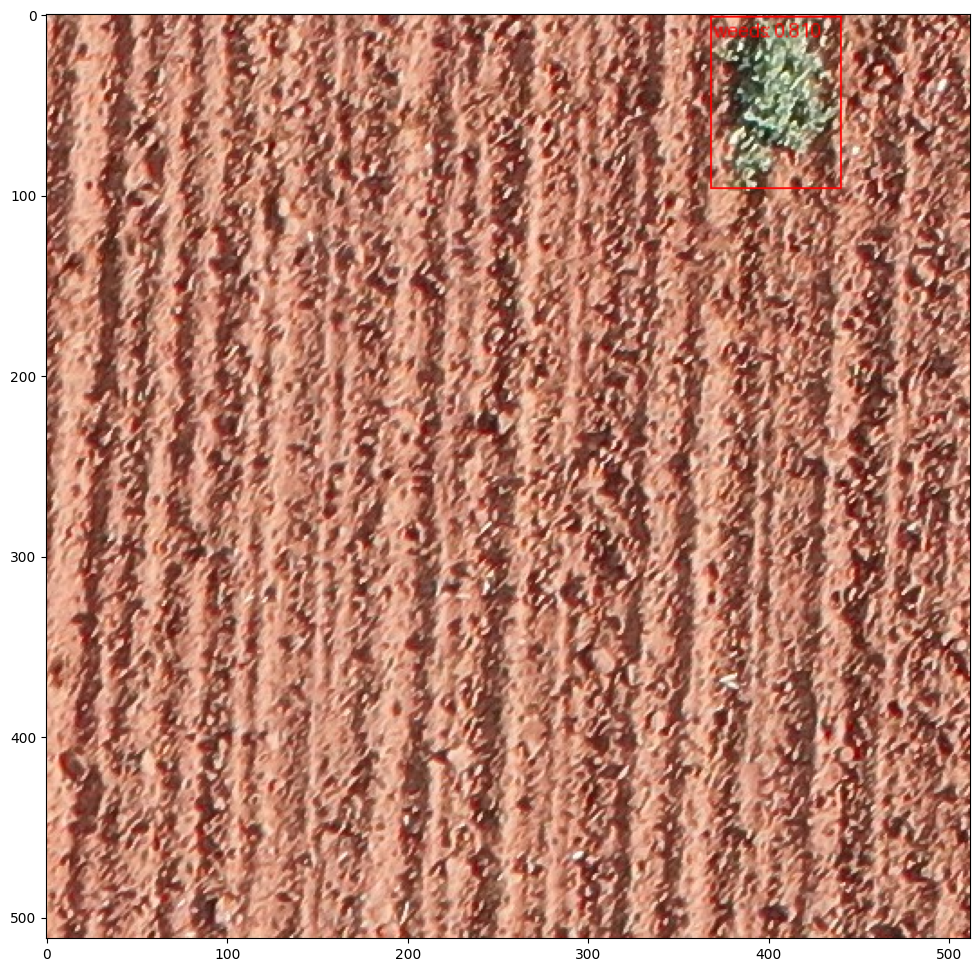

Inference time: 0.1910 seconds
FPS: 5.24


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

image = read_image("/content/drive/MyDrive/ColabNotebooks/cut_down_data_v2/images/DJI_20240221090315_0001_13.png")
eval_transform = get_transform(train=False)  # Assuming you have get_transform function

model.to(device)
model.eval()

start_time = time.time()  # Initialize start_time before inference
with torch.no_grad():
    x = eval_transform(image)
    x = x[:3, ...].to(device)  # Convert to RGB and move to device
    predictions = model([x])  # Inference happens here
    end_time = time.time()   # Record end_time immediately after inference
    inference_time = end_time - start_time

    pred = predictions[0]

    # 1. Filter predictions based on confidence score (adjust threshold as needed)
    confidence_threshold = 0.65
    confident_indices = pred["scores"] > confidence_threshold
    pred_boxes = pred["boxes"][confident_indices].long()
    pred_labels = [f"weeds: {score:.3f}" for label, score in zip(pred["labels"][confident_indices], pred["scores"][confident_indices])]

    # 2. Ensure pred_boxes are in the correct format (x1, y1, x2, y2)
    #    If not, convert them here if necessary

    # 3. Ensure data type consistency
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]  # Convert to RGB

    # Draw bounding boxes
    output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# Calculate FPS
fps = 1 / inference_time

# Display the image and inference time
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()

print(f"Inference time: {inference_time:.4f} seconds")
print(f"FPS: {fps:.2f}")  # Print FPS with 2 decimal places

In [ ]:
%pip install torcheval


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 11.3 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal